In [1]:
from efficient_rerank import run_pipeline, XLMCometEmbeds
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
import pickle
import pandas as pd
import os
from src.recom_search.model.beam_node_reverse import ReverseNode
import numpy as np
import math 
from new_flatten_lattice import get_dictlist
import flatten_lattice as fl
xlm_tok = fl.bert_tok


2022-11-05 08:03:14.752397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 08:03:14.752419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from new_mask_utils import *

In [3]:
# load in model, for french
#del model
model = XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/maskedcont4.pt"))
model.eval()
torch.cuda.memory_allocated(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1112257024

In [4]:
frpreds = pd.read_csv('torchsaved/frenchlatpreds')

In [ ]:
frpreds.loc[0]['ahyp']

In [6]:
frpreds.loc[0]['ref']

'After all, as a campaigning investigative journalist she made many people angry besides Putin, not least of which is the current Chechen Prime Minister, Ramzan Kadyrov, whom she accused of a policy of kidnapping for ransom. '

In [5]:
base = "frtest_reversed/"

def test_flatten(ind, basedir):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    #if g['input'] in old['src']:
    #    return None, None, None
    #try:
    return get_dictlist(g, True)

def test_graph_ind(ind, basedir, scofunct):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    #if g['input'] in old['src']:
    #    return None, None, None
    #try:
    return g['input'], g['ref'], run_pipeline(g, model, scofunct)
    #flattened, flnodes
    
def test_graph_verb(ind, basedir, scofunct):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    return run_pipeline(g, model, scofunct, True)

def get_all_preds(basedir, scofunct):
    l = len(os.listdir(basedir))
    res = []
    print(l)
    for i in range(l):
        inp, r, p = test_graph_ind(i, basedir, scofunct)
        res.append({
            'src':inp,
            'hyp':p,
            'ref':r
        })
        print(i)
    res = pd.DataFrame(res)
    res.to_csv("latfound2"+basedir[:-4]+".csv")
    return res

In [40]:
def default_scofunct (node):
    try:
        return node['score']
    except:
        print(node)

#pcnt = 0
#npcnt = 0
def addprob (node):
    global pcnt, npcnt
    if "prob" in node.keys():
        #pcnt+=1
        return math.log(node['prob']) + node['score']
    else:
        #npcnt+=1
        return 1

In [41]:
pcnt

318

In [42]:
best , flattened, prepared_pgraphs, mask, sents, posids, pred, posadd, flnodes = test_graph_verb(0, base, default_scofunct)

original nodes -  682
final detokd -  706
{'token_idx': 111, 'token_str': 'of', 'pos': 122, 'id': 'H6NOF3IZG9', 'nexts': ['JUWA0T79P8PL7J9CZCCL0'], 'prob': 0.9065045118331909, 'bestsco': 0, 'plist': []}


TypeError: unsupported operand type(s) for +: 'NoneType' and 'Tensor'

In [8]:
flattened[34:]

[{'token_idx': 77336,
  'token_str': 'variable',
  'pos': 34,
  'id': '2UD2Q8TZFM',
  'nexts': ['OL0ODKW4AM'],
  'prob': 0.834183931350708,
  'score': tensor(-0.0026, device='cuda:1'),
  'bestsco': tensor(0.2175, device='cuda:1'),
  'plist': [192,
   193,
   194,
   195,
   196,
   197,
   204,
   205,
   206,
   207,
   213,
   301,
   305,
   306,
   307,
   308,
   309,
   310]},
 {'token_idx': 83,
  'token_str': 'is',
  'pos': 35,
  'id': 'OL0ODKW4AM',
  'nexts': ['IOI40AS1LZ'],
  'prob': 0.703538179397583,
  'score': tensor(-0.0026, device='cuda:1'),
  'bestsco': tensor(0.2201, device='cuda:1'),
  'plist': [192,
   193,
   194,
   195,
   196,
   197,
   204,
   205,
   206,
   207,
   213,
   301,
   305,
   306,
   307,
   308,
   309]},
 {'token_idx': 70,
  'token_str': 'the',
  'pos': 36,
  'id': 'IOI40AS1LZ',
  'nexts': ['KJ4SLMO0T4', 'H2WE4ARPYL', '4QGYU2D8S2'],
  'prob': 0.7241314649581909,
  'score': tensor(-0.0025, device='cuda:1'),
  'bestsco': tensor(0.2226, device='cud

In [16]:
import math

In [20]:
len(flnodes)

318

In [17]:
# sanity checks - 
# - are the scores actually storing probabilities? YES
# - flnodes has different length than flattened? nevermind that's just because of weirdness from earlier
[math.log(fl.prob) for fl in flnodes]

[0.0,
 -1.5989558937222998,
 -0.1813013597511238,
 -0.3516331332569609,
 -0.3227823216463685,
 -0.6557158996360548,
 -0.12580278611123005,
 -0.08149015580082938,
 -0.7052639305458258,
 0.0,
 -0.39487052642663395,
 -0.5091534830931905,
 -0.26016049419274073,
 -0.1254222977907736,
 -0.19710340971647797,
 -0.35814768359699567,
 -1.0832129824628736,
 -0.24623512067011258,
 -0.4733187271614617,
 0.0,
 -3.223719282884454,
 0.0,
 0.0,
 -3.694650154019061,
 0.0,
 0.0,
 -3.944857810108654,
 0.0,
 -5.227698091217248,
 0.0,
 -3.176313133491951,
 0.0,
 -3.6617139189595336,
 -1.3002440188584987,
 0.0,
 -4.520192408057059,
 0.0,
 0.0,
 -5.103229671265321,
 0.0,
 0.0,
 -1.1084299731158587,
 -0.8272102516926484,
 -0.5915682931175584,
 0.0,
 -2.6996451682006817,
 0.0,
 0.0,
 -3.256351989186881,
 0.0,
 0.0,
 -4.0062646860830045,
 0.0,
 -2.6197388135920106,
 0.0,
 0.0,
 -2.7079574926992938,
 0.0,
 -3.2912367380882657,
 -0.15748671728307148,
 -0.30608020925327406,
 0.0,
 -3.6537564328038763,
 0.0,
 0.0,
 

In [11]:
mask[32:, 32:][10]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
prepared_pgraphs

In [6]:
torch.sum(mask[32])

tensor(33.)

In [41]:
def vis_context(ind):
    row = mask[ind]
    cont = " " 
    indtmp = 0
    for c in row:
        if c>0:
            cont = cont + " " + xlm_tok.decode(sents[0][indtmp])
        indtmp+=1
    cont += " : " +xlm_tok.decode(sents[0][ind])
    return cont[160:]

In [16]:
mask[32:350, 32:350][60]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [10]:
mlen = min(512-(posadd+1), len(flnodes))
maxpos = mask_prep_canv(flnodes)
back_adjac = adj_mat(flnodes, mlen)

In [24]:
flnodes[5].prevs[0].token_str

'the'

In [ ]:
tot = back_adjac
tmp = back_adjac
# keep on going until all nodes hit the back
while torch.sum((tot[:, 0]>0))<(mlen-1):
    tmp = torch.mm(back_adjac, tmp)
    tot += tmp
tot = tot+ torch.eye(mlen)
return (tot>0).int()

In [24]:
# best , flattened, prepared_pgraphs, mask, sents, posids, pred

decs = [xlm_tok.decode(d['token_idx']) for d in flattened]
for d in decs:
    print(d)

<s>
Après
tout
,
en
tant
que
journalist
e
d
'
invest
i
gation
en
campagne
,
elle
a
en
ra
gé
beaucoup
d
'
autres
gens
out
re
Pou
tine
,
parmi
lesquels
l
'
act
uel
Premier
ministre
t
ché
t
chè
ne
Ram
zan
Kad
y
rov
n
'
est
pas
des
moindre
s
,
qu
'
elle
a
accu
sé
de
mener
une
politique
d
'
en
lè
ve
ments
contre
ran
çon
s
.
</s>
<s>
After
all
,
as
a
field
investiga
tive
journalist
she
has
in
stille
d
in
many
people
besi
des
Putin
,
including
the
current
Che
chen
Prime
Minister
Ram
zan
Kad
y
rov
,
not
the
least
of
whom
she
has
accu
sed
of
conduct
ing
a
policy
of
kidnap
ping
for
ran
som
.
a
policy
of
kidnap
ping
for
ran
som
.
pur
su
ing
a
policy
of
kidnap
ping
for
ran
som
.
ab
duction
s
for
ran
som
.
bri
ber
y
-
for
-
mone
y
policy
.
journalist
,
she
has
in
stille
d
in
many
people
besi
des
Putin
,
including
the
current
Che
chen
Prime
Minister
Ram
zan
Kad
y
rov
not
the
least
,
a
policy
of
Kad
y
rov
,
not
the
least
of
whom
she
has
accu
sed
of
conduct
ing
a
policy
of
kidnap
ping
for
ran
som
.
ab

In [9]:
len(retvals)

7

In [12]:
len(ppres)

2

In [ ]:
frpreds = get_all_preds("frtest_reversed/")

In [ ]:
depreds = get_all_preds("detest_reversed/")

In [28]:
basedir = "frtest_reversed/"
l = len(os.listdir(basedir))
res = []

In [ ]:
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    if i==None:
        continue
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
frpreds = resdf
#resdf.to_csv("frenchlatpreds")

In [ ]:
del model
model = er.XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/germanlat0.pt"))
model.eval()

In [ ]:
basedir = "detest_reversed/"
l = len(os.listdir(basedir))
res = []
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
depreds = resdf.to_csv("germanlatpreds")

In [40]:
resdf

,src,hyp,ref
0,"By the time Mao Zedong died, in 1976, the rura...","<s> By the time Mao Zedong died, in 1976, the ...","Als Mao Tse-Tung im Jahr 1976 starb, lag die W..."
1,(If the TTIP was opened to other economies – s...,<s> (If the TTIP was opened to other economies...,(Würde TTIP für andere Volkswirtschaften – wie...
2,"On the other hand, China remains trapped by a ...","<s> On the other hand, China remains trapped b...",Auf der anderen Seite bleibt China seiner Verg...
3,"(Simonyi wrote the Microsoft Word program, and...","<s> (Simonyi wrote the Microsoft Word program,...",(Simonyi entwickelte das Programm Microsoft Wo...
4,Everyone agrees that Iran has the right to do ...,<s> Everyone agrees that Iran has the right to...,"Alle sind sich einig, dass dem Iran das Recht ..."
...,...,...,...
1072,But this does not mean that we should just cut...,<s> But this does not mean that we should just...,"Aber das heißt nicht, dass wir einfach auf all..."
1073,It might seem from these numbers that Europe h...,<s> It might seem from these numbers that Euro...,"Aus diesen Zahlen könnte man ableiten, dass di..."
1074,"In other words, the structures that companies ...","<s> In other words, the structures that compan...","Anders ausgedrückt: Die Strukturen, die Untern..."
1075,"On October 24, you can stand up against this i...","<s> On October 24, you can stand up against th...","Am 24. Oktober besteht die Möglichkeit, gegen ..."


In [74]:
frpreds = pd.read_csv("frenchlatpreds")

In [65]:
depreds.loc[0]['hyp']

'<s> By the time Mao Zedong died, in 1976, the rural economy was a shambles.</s><s> de_DE Bei der Todestagszeit Mao Zedongs, im Jahr 1976, war die ländliche Wirtschaft in einem Schlamm.'

In [75]:
def get_act_hyps(hyplist, cutoff):
    res = []
    for h in hyplist:
        cind = h[3:].index(cutoff)+len(cutoff)+3
        res.append(h[cind:])
    return res

In [76]:
frpreds['ahyp'] = get_act_hyps(frpreds['hyp'], "<s>")

In [77]:
frpreds

,Unnamed: 0,src,hyp,ref,ahyp
0,0,"Après tout, en tant que journaliste d'investig...","<s> Après tout, en tant que journaliste d'inve...","After all, as a campaigning investigative jour...","After all, as an investigative reporter in th..."
1,1,Au fur et à mesure que l’Iran a cherché à éten...,<s> Au fur et à mesure que l’Iran a cherché à ...,As Iran seeks to assert its influence and inte...,As Iran sought to extend its influence and ad...
2,2,Une autre variable réside dans la question de ...,<s> Une autre variable réside dans la question...,Another variable is how much easier monetary p...,The other variable is the extent to which oth...
3,3,Il nous faut négocier un nouvel accord de part...,<s> Il nous faut négocier un nouvel accord de ...,A new Partnership and Cooperation Agreement (P...,We need to negotiate a new partnership and co...
4,4,Et lorsqu’une région du monde conçoit une meil...,<s> Et lorsqu’une région du monde conçoit une ...,And as one region in one part of the world des...,And when a region of the world devises better...
...,...,...,...,...,...
839,839,"Au moment même de lire ces lignes, des personn...","<s> Au moment même de lire ces lignes, des per...","As you read this, perfectly ordinary people so...","At the very time of reading these lines, perf..."
840,840,C’est ainsi que les médias traditionnels se so...,<s> C’est ainsi que les médias traditionnels s...,"As a result, mainstream media are being margin...","As a result, the traditional media have progr..."
841,841,Un troisième impératif est de construire un mo...,<s> Un troisième impératif est de construire u...,A third imperative is building a safer and mor...,A third imperative is the building of a safer...
842,842,Une approche « portefeuille » du changement cl...,<s> Une approche « portefeuille » du changemen...,A “Portfolio” Approach to Climate Change,"A ""portfolio "" approach to global climate cha..."


In [78]:
def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outputs = comet.predict(
        cometqe_input, batch_size=32, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

In [79]:
cometqe_dir = "./cometqemodel"
# can alternatively use wmt21-comet-qe-mqm
cometqe_model = "wmt20-comet-qe-da"
cometmodel = "wmt20-comet-da"
batch_size = 64
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [80]:
from comet import download_model, load_from_checkpoint


In [ ]:
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path)
comet.to(device)

In [56]:
del model

In [ ]:
scos = get_comet_scores(frpreds['ahyp'], frpreds['src'], frpreds['ref'])

In [82]:
frpreds['scos'] = scos[0]

In [83]:
frpreds.to_csv("frenchlatpreds")

In [94]:
frpreds[frpreds['scos']<0].loc[25]['ref']

'Already nearly everybody in the North Atlantic region has enough food to avoid hunger, enough clothing to stay warm, enough shelter to remain dry. And yet we want more, feel resentful when we do not get it, and are self-aware enough to know that luxuries turn into conveniences, and then into necessities – and that we are very good at inventing new luxuries after which to strive. '

In [97]:
sum(depreds['scos'])/1077

0.03813996849133665

In [100]:
import matplotlib.pyplot as plt

(array([  3.,   8.,  28.,  12.,  14.,  14.,  64., 110., 374., 217.]),
 array([-1.84165907, -1.55159155, -1.26152403, -0.97145652, -0.681389  ,
        -0.39132148, -0.10125396,  0.18881356,  0.47888107,  0.76894859,
         1.05901611]),
 <BarContainer object of 10 artists>)

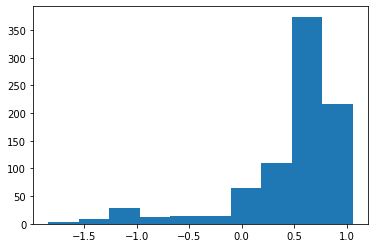

In [101]:
plt.hist(frpreds['scos'])

In [17]:
tok = fl.bert_tok

In [5]:
graph = pickle.load(open(base+str(2), 'rb'))

In [7]:
graph['root'].prevs

AttributeError: 'ReverseNode' object has no attribute 'prevs'

In [15]:
# Debugging stuff out 
# override this function
# TODO will need to update if there are new changes
flattened = fl.flatten_lattice(graph)
ppinput = prepend_input(flattened, graph['input'])
flattened = ppinput[0]
covered = fl.get_cover_paths(flattened)

In [56]:
def find_tind(ftd, val):
    finds = []
    ind = 0
    for t in ftd:
        if val in tok.decode(t['token_idx']):
            print(tok.decode(t['token_idx']))
            print(ind)
            finds.append(ind)
            
        ind+=1
    return finds

def find_byid(ftd, idval):
    i = 0
    for t in ftd:
        
        if t['id']==idval:
            print(i)
            return t
        i+=1
    return None

def track_to_end(ftd, tstart):
    cur = tstart
    while len(cur['nexts'])>0:
        print(tok.decode(cur['token_idx']))
        #print(len(cur['nexts']))
        itmp = -1
        while find_byid(ftd, cur['nexts'][itmp]) is None:
            itmp-=1
        cur = find_byid(ftd, cur['nexts'][itmp])
find_tind(flattened, "Another")

Another
335


[335]

In [57]:
flattened[351]

{'token_idx': 44930,
 'pos': 42,
 'id': '44930 42',
 'nexts': ['2 43'],
 'score': tensor(-0.0026, device='cuda:1'),
 'bestsco': tensor(-0.0026, device='cuda:1'),
 'plist': [0]}

In [58]:
track_to_end(flattened, flattened[335])

Another
336
336
variable
337
337
is
338
338
the
344
344
degree
345
345
to
346
346
which
349
349
monetar
350
350
y
351
351
policy


IndexError: list index out of range

In [62]:
find_byid(flattened, '3789 40')

348


{'token_idx': 3789,
 'pos': 40,
 'id': '3789 40',
 'nexts': ['2 41'],
 'score': tensor(-0.0026, device='cuda:1'),
 'bestsco': tensor(-0.0026, device='cuda:1'),
 'plist': [3]}

In [64]:
tok.decode(2)

'</s>'

In [20]:
len(flattened)
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
# We got - The other variable is the extent to which other developed economies’ monetary policies will become more liberal.

352

In [13]:
posadd = ppinput[1]
mask = causal_mask(flattened, posadd)
sents, posids = create_inputs([flattened])
with torch.no_grad():
    pred = model(sents, posids, mask.unsqueeze(0).to(device))
fls = [flattened]
prepared_pgraphs = prepare_pgraphs(fls, pred[0])
bestpath = dp_pgraph(prepared_pgraphs[0])
best = xlm_tok.decode(bestpath)
print("SRC - "+graph['input'])
print("PRED - "+best)
print("REF - "+graph['ref'])
# return best, covered, flattened, prepared_pgraphs, mask, sents, posids, pred

tensor(0.1001, device='cuda:1')
SRC - Une autre variable réside dans la question de savoir dans quelle mesure les politiques monétaires des autres pays développés s’assoupliront. 
PRED - <s> Une autre variable réside dans la question de savoir dans quelle mesure les politiques monétaires des autres pays développés s’assoupliront.</s><s> The other variable is the extent to which other developed economies’ monetary policies will become more liberal.
REF - Another variable is how much easier monetary policies in other developed countries will become. 


In [25]:
tok.decode([t['token_idx'] for t in prepared_pgraphs[0]])

'policyy monetar other the which to degree to extent the of question the is variable Another more becoming are. flexible more becomes economie more become more be willtions na developed countries be wills economie advanced other other more become more be.ase e will world developed the of rest the in developed other the of more be will policiess economie developed others economie developed other the in are become would. flexible more become may countries developed other in flexible more be will policyy monetar more be more become will policyy monetar’. policiesy monetar theirase e will countries.tive accommoda.ed relax. liberal more. flexible less.ser loo become.tive accommoda.ed relax. liberal more. flexible.ed relax.ingas e.ser loo be.se acembra  e. relax will. flexible more become more becoming are. flexible more become more be would policiesy monetar’s economie developed others economie developed become be will countries advanced other are become countries.tive accommoda more become

In [76]:
graph['root'].nextlist[0].nextlist[1].token_str

'The'

In [80]:
def vis_node(node):
    for no in node.nextlist:
        print(no.token_str)

In [99]:
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
vis_node(n)

.


In [100]:
n.prob

0.8566898107528687

In [3]:
base = "frtest_reversed/"


In [1]:
from new_flatten_lattice import get_dictlist
import os

2022-10-31 03:29:13.739235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 03:29:13.739256: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
flatlat = get_dictlist(base+str(5))

original nodes -  428
final detokd -  446


In [5]:
overcnt

174

In [ ]:
overcnt = 0
for ind in range(450):
    fl = get_dictlist(base+str(ind))

    if len(fl)>450:
        overcnt+=1
overcnt


In [2]:
class DLReverseNode():
    def _get_dictlist_(self, oldnode):
        self.uid = oldnode.uid
        self.prob = oldnode.prob
        self.token_idx = oldnode.token_idx
        self.token_str = oldnode.token_str
        self.nextlist = oldnode.nextlist
        self.next_scores = oldnode.next_scores
        self.next_ids = oldnode.next_ids
        self.prevs = []
        self.detoks = []
        self.pos = -1
        self.canvpos = 1000
        if oldnode.pos>0:
            self.prevs = oldnode.prevs
            self.pos = oldnode.pos
            self.detoks = oldnode.detoks
            self.canvpos = oldnode.canvpos
        
    def __str__(self):
        return self.token_str

In [86]:
del dblgrph

In [3]:
base = "frtest_reversed/"
toker = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")
detok = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [17]:
# TODO later on just move this to the initial graph reversal
def get_dbl_graph(grph):
    newgrph = {}
    for g in grph.keys():
        if g=="input" or g== "ref" or g== "rootid":
            continue
        tmp = DLReverseNode(grph[g])
        newgrph[g] = tmp
    for gk in newgrph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        # this should handle everything having a previous list
        newgrph[gk].nextlist = None
        newgrph[gk].nextlist = [newgrph[idl] for idl in newgrph[gk].next_ids]
    for gk in newgrph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        for n in newgrph[gk].nextlist:
            n.prevs.append(newgrph[gk])
        newgrph[gk].token_idx = [newgrph[gk].token_idx]
    # TODO do something to update scores on word graph
    return newgrph

# greedily traverse graph, run function on each node
def greedy_traverse(gr, fun, norev=True):
    queue = []
    queue.append(gr['root'])
    visited = []
    while len(queue)>0:
        cur = queue.pop()
        fun(cur, gr)
        order = np.argsort([n.prob for n in cur.nextlist])
        # highest prob gets popped off first
        for o in order:
            if cur.uid not in visited:
                queue.append(cur.nextlist[o])
        visited.append(cur.uid)
                
# make so graph has word-only nodes, check tokenization at different node boundaries
# update pointers afterwards
def combine_nodes(gr):
    dblgrph = get_dbl_graph(gr)
    #print("Doubly Linked - ", len(dblgrph.keys()))
    greedy_traverse(dblgrph, consolidate_node)
    rmlist = []
    for d in dblgrph.keys():
        if d=="input" or d== "ref" or "root" in d:
            continue
        if len(dblgrph[d].prevs)==0:
            rmlist.append(d)
    for r in rmlist:
        del dblgrph[r]
    return dblgrph

# do this on every node greedily to get flattened lattice canvas
def add_to_flat(node, grph):
    global flat
    if node.canvpos<1000:
        return
    flat.append(node)
    # get detokenization
    detok_tmp = detok(node.token_str).input_ids[1:-1]
    # update pos on first greedy hit
    if len(node.prevs)==0:
        node.pos = -1 + len(detok_tmp)
    if node.pos==-1:
        node.pos = max([n.pos for n in node.prevs])+len(detok_tmp)
    node.detoks = detok_tmp
    node.canvpos = len(flat)-2+ len(detok_tmp)
    
flat = []
def get_flat_lattice(gr):
    global flat
    flat = []
    wordgraph = combine_nodes(gr)
    # print("Combined nodes - ", len(wordgraph))
    # clear out prevs
    for gk in wordgraph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        wordgraph[gk].prevs = []
    # reset prevs
    for gk in wordgraph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        for n in wordgraph[gk].nextlist:
            n.prevs.append(wordgraph[gk])
    greedy_traverse(wordgraph, add_to_flat)
    # print("Greedy traversal - ", len(flat))
    cp = [f for f in flat]
    return cp

def split_dl_node(node):
    if len(node.detoks)==1:
        return [node]
    res = []
    # update previous of nodes
    for i in range(len(node.detoks)):
        n = node.detoks[i]
        # make a copy of our base node
        tmp = DLReverseNode(node)
        if i>0:
            tmp.prevs = [res[-1]]
            # only have probability on 1
            tmp.prob = 1
        tmp.uid = tmp.uid+str(i)
        tmp.pos = tmp.pos - (len(node.detoks)-i-1)
        tmp.canvpos = tmp.canvpos - (len(node.detoks)-i-1)
        tmp.token_idx = n
        tmp.token_str = detok.decode(n)
        res.append(tmp)
    # update next connection of nodes
    for i in range(len(res)-1):
        if i<(len(node.detoks)-1):
            res[i].next_ids = [res[i+1].uid]
            res[i].nexts = [res[i+1]]
    return res
        
def tokenize_flat_lattice(gr):
    # get rid of first token, usually en_XX for french
    print("original nodes - ", len(gr.keys()))
    tmplist = gr['root'].nextlist[0].nextlist
    tmpids = gr['root'].nextlist[0].next_ids
    gr['root'].nextlist = tmplist
    gr['root'].next_ids = tmpids
    flatlat = get_flat_lattice(gr)
    res = []
    #print("flatlat - ", len(flatlat))

    for f in flatlat:
        res.extend(split_dl_node(f))
    print("final detokd - ", len(res))
    return res
    # we need to go through and convert this into lattices compatible 
    # with the format further into the pipeline, need to tokenize again with BERT
    
# disconnect / throw away node
def throw_garbage(node, grph, lprevs=False):
    assert len(node.prevs)==0 or len(node.nextlist)==0
    for pre in node.prevs:
        if node in pre.nextlist:
            pre.nextlist.remove(node)
        if node.uid in pre.next_ids:
            pre.next_ids.remove(node.uid)

    if lprevs:
        for n in node.nextlist:
            n.prevs.remove(node)
    if node.uid not in grph.keys():
        #print("w")
        ""
    else:
        del grph[node.uid]
        
# assume that previous nodes are consolidated, 
def consolidate_node(node, grph):
    if node.uid not in grph.keys():
        return
    goneprevs = []
    # check relationship with all previous nodes
    for prev in node.prevs:
        # it's a word boundary, no changes
        comb = toker.decode(prev.token_idx+node.token_idx)
        if " " in comb or "</s>" in comb:
            continue
        else:
            # need to make new node, add necessary stuff
            #print(comb)
            tmp = DLReverseNode(node)
            tmp.token_str = comb
            tmp.token_idx = prev.token_idx+node.token_idx
            tmp.prob = prev.prob*node.prob
            tmp.prevs = []
            tmp.prevs.extend(prev.prevs)
            tmp.uid = prev.uid+node.uid
            
            # connect previous nodes
            for pre in tmp.prevs:
                pre.nextlist.append(tmp)
                pre.next_ids.append(tmp.uid)
            
            grph[tmp.uid] = tmp
            # cut off from others where necessary
            goneprevs.append(prev)
            
            if node in prev.nextlist:
                prev.nextlist.remove(node)
                if node.uid in prev.next_ids:
                    prev.next_ids.remove(node.uid)
            
            for t in tmp.nextlist:
                t.prevs.append(tmp)
            # prev now garbage, delete it
            if len(prev.nextlist)==0:
                throw_garbage(prev, grph, True)
            """
            if comb=="China’":
                print("nexts after", len(tmp.nextlist))
                print(tmp.uid)
                print(tmp.nextlist[0].prevs[1].uid)
            """
            
    for g in goneprevs:
        node.prevs.remove(g)
    if len(node.prevs)==0:
        throw_garbage(node, grph)
        

def get_dictlist(grphinp):
    fllat = tokenize_flat_lattice(grphinp)
    tdicts = []
    for f in fllat:
        tdicts.append({
            'token_idx': f.token_idx,
            'pos': f.pos, 
            'id': f.uid,
            'nexts': [fn.uid for fn in f.nextlist], 
            'score': math.log(f.prob)
        })

In [19]:
import math

In [20]:
graph = pickle.load(open(base+str(0), 'rb'))
flatlat = get_dictlist(graph)

original nodes -  682
final detokd -  706


In [ ]:
for i in range(75):
    graph = pickle.load(open(base+str(i), 'rb'))
    flatlat = tokenize_flat_lattice(graph)
    print(len(flatlat))
    #combnodes = combine_nodes(graph)

In [ ]:
def check_duptok(flat, ind):
    check = flat[ind]
    prestrs = set([fla.uid for fla in check.prevs])
    nestrs = set([ns.token_str for ns in check.nextlist])
    others = flat[:ind]
    if ind<len(flat)-1:
        others.extend(flat[ind+1:])
    res = []
    for f in others:
        if check.token_str==f.token_str:
            
            if prestrs==set([fla.uid for fla in f.prevs]):
                res.append(f.token_str)
    return res
"""
TODO look into issue of duplicates

bigre = []
for i in range(len(flatlat)-1):
    print(check_duptok(flatlat, i))
"""


In [34]:
combnodes['root'].nextlist

In [28]:
toker.decode([9098, 26, 7])

'China’s'

In [27]:
graph['root'].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].token_idx

9098

In [73]:
for gk in combnodes.keys():
    if len(combnodes[gk].nextlist)==0:
        print(combnodes[gk].token_str)

</s>
5.7%.
.
percent.
percent.
11.2%.
period.
period.
period.
period.
period.
period.
period.
period.
period.
period.
period.
period.
5.7%.
11.2%.
cent.
11.2%.


In [105]:
len(flatlat)

13

In [106]:
[f.token_str+" "+str(f.pos) for f in flatlat]

['</s> 0',
 'According 1',
 'to 2',
 'the 3',
 'IMF 4',
 ', 5',
 'annual 6',
 'growth 7',
 'in 8',
 'China 9',
 '’ 10',
 'China 6',
 '’ 7']

In [80]:
gra = combine_nodes(graph)
weirds = []
print(len(gra.keys()))
for gk in gra.keys():
    if gk=="input" or gk== "ref" or gk== "rootid":
        continue
    print(gra[gk])
    if len(gra[gk].nextlist)==0:
        
        weirds.append(gra[gk])

KeyError: '18NJKKHSH23R9FVYO1QW'

In [154]:
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
node = gra['root'].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[2].nextlist[0].nextlist[0].nextlist[1].nextlist[0].nextlist[1].nextlist[0].nextlist[0].nextlist[0].nextlist[2]
for n in node.nextlist:
    print(n)

In [54]:
toker = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")

In [68]:
doublegraph = get_dbl_graph(graph)

In [73]:
doublegraph['root'].nextlist

In [28]:
combine_nodes(graph)

AttributeError: 'ReverseNode' object has no attribute 'prevs'

In [10]:
# TODO delete if not useful
def update_node_prevs(dblgraph, node):
    # check if already in existing nodes
    if node.uid in dblgraph.keys():
        return
    # TODO make sure to use the right kind of node
    cur = node
    while len(cur.nextlist)==1:
        if cur.nextlist[0].uid in dblgraph.keys():
            tmp = dblgraph[cur.nextlist[0].uid]
        else:
            tmp = DLReverseNode(cur.nextlist[0])
        tmp.prevs.append(cur)
        # don't keep going if we've already done this node at some point
        if cur.nextlist[0].uid in dblgraph.keys():
            return 
        dblgraph[cur.nextlist[0].uid] = tmp
        cur = tmp
    # hit the end of segment, multiple choices now
    if len(cur.nextlist)>1:
        for n in cur.nextlist:
            if n.uid in dblgraph.keys():
                nnode = dblgraph[n.uid]
            else:
                nnode = DLReverseNode(n)
            nnode.prevs.append(cur)
            dblgraph[n.uid] = nnode
            update_node_prevs(dblgraph, n)
    

In [53]:
graph['root'].nextlist[0].prevs[1].token_str

'</s>'

In [ ]:
# flatten out lattice 
def flatten_lattice(graph):
    tokdicts = []
    visited = []
    prev_contig = []
    greedy_flatten(tokdicts, visited, graph['root'], 0, prev_contig, set())
    #greedy_flat_old(tokdicts, visited, graph['root'], 0)
    return tokdicts

max_splits = -1
splits_hit = 0
# flattens graph by position, ignores </s> and en_XX tokens for greater BERT compatibility
# TODO set up to use mbart tokenization
def greedy_flatten(tdicts, visited, node, pos, prev_cont, added_ids, branch_start=None):
    global splits_hit
    if node.uid in visited:
        return
    if node.token_idx==2 or node.token_idx==250004:
        npos = pos
    else:
        node.pos = pos
        
        visited.append(node.uid)
        npos = pos+1
        s = node.token_str
        prev_cont.append(node)
    
    olen = len(tdicts)
    # we're hitting a branch or an ending, update to bert tokenization and add to visited
    # should be ok to do this since branching / merging only happens at word boundaries (presumably)
    branched = (len(node.next_scores)>1)
    end = (len(node.next_scores)==0)
    merge = end==False and node.nextlist[0].uid in visited
    if branched or merge or end:
        if len(prev_cont)>0:
            errorflag = False
            
            prev_update = []
            for p in prev_cont:
                if p.uid in added_ids:
                    continue
                else:
                    prev_update.append(p)
                    added_ids.add(p.uid)
            
            if len(prev_update)>0:
                toktmp = get_toklist(prev_update)
                for i in range(1, len(prev_update)):
                    if prev_update[-(i+1)].pos>=prev_update[-i].pos:
                        errorflag = True
                        break
                decstr = mbart_tok.decode(toktmp)
                if errorflag:
                    #print(decstr)
                    #print([p.pos for p in prev_update])
                    ""
                bert_toks = bert_tok(decstr).input_ids
                curpos = prev_update[0].pos
                # TODO add logic that tracks scores / next nodes
                otdlen = len(tdicts)
                for bind in range(0, len(bert_toks)):
                    b = bert_toks[bind]
                    # change to 101, 102 for bert, change to 0, 2 for xlm
                    if b==0 or b==2:
                        continue
                    nid = str(b)+" "+str(curpos)
                    # if we're at the start, add this node to next of branch node
                    if len(tdicts)==otdlen and branch_start is not None:
                        branch_start['nexts'].append(nid)

                    if bind<len(bert_toks)-1:
                        tdicts.append({
                            'token_idx':b,
                            'pos':curpos, 
                            'id': nid,
                            'nexts': [str(bert_toks[bind+1])+" "+str(curpos+1)], 
                            'score': 0
                        })
                    else:
                        tdicts.append({
                            'token_idx':b,
                            'pos':curpos, 
                            'id': str(b)+" "+str(pos),
                            'nexts': [], 
                            'score': 0
                        })
                    curpos+=1
                if merge or end:
                    splits_hit+=1
            
    if len(tdicts)>olen:
        del prev_cont
        prev_cont = []
        
    # end things early if we want to limit paths
    if max_splits>=0 and splits_hit>=max_splits:
        return 
    
    scosort = list(np.argsort(node.next_scores))
    if branched and len(tdicts)>0:
        branch_start=tdicts[-1]
    # TODO check which direction we need to go from argsort
    for i in range(0, len(scosort)):
        greedy_flatten(tdicts, visited, node.nextlist[scosort[i]], npos, prev_cont, added_ids, branch_start)